This is a script to drive the auroral precipitation model OVATION Prime 2010 model described by [Newell et al., 2009](https://doi.org/10.1029/2009JA014326) and [Newell et al. 2010](https://doi.org/10.1029/2009JA014805) as a demonstration to begin designing the Space Weather portion of the Synthetic Environment (e.g., with [RWI Synthetics](https://rwisynthetics.com/))

This script uses the [OvationPyme](https://github.com/lkilcommons/OvationPyme) Python module written by Liam Kilcommons. 

The auroral model is evaluated given an input datetime, and automatically obtains the solar wind data for that time using [nasaomnireader](https://github.com/lkilcommons/nasaomnireader). To run the model for any input solar wind data (such as the sample solar wind input data generated from [Create Synthetic SW Data.ipynb](https://github.com/rmcgranaghan/NSF_CHESS/blob/master/SyntheticEnvironment/Create%20Synthetic%20SW%20Data.ipynb)), a different method will be needed. Options include using the SWPC version of OVATION or a replacement precipitation model described by [McGranaghan et al., [2021]](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020SW002684)



In [20]:
import numpy as np
import pandas as pd
import datetime as dt
import xarray

from pathlib import Path

import matplotlib.pyplot as plt

from ovationpyme import ovation_prime
from ovationpyme import ovation_utilities
from ovationpyme.ovation_plotting import latlt2polar,polar2dial,pcolor_flux


In [26]:
data_folder = Path("../data/")


The following command generates a full auroral precipitation energy map for a given input time step

In [23]:
datetime_input = dt.datetime(2003,10,30,18)


auroral_flux_types = ['diff','mono','wave']

flag = 0

for a_type in auroral_flux_types:
    print('working on auroral_flux_type = {}'.format(a_type))
    estimator_e = ovation_prime.FluxEstimator(a_type,energy_or_number='energy')
    mlat_grid_ovation, mlt_grid_ovation, eFlux_ovation_tmp = estimator_e.get_flux_for_time(datetime_input,
                                                                                           hemi='N',
                                                                                           return_dF=False,
                                                                                           combine_hemispheres=True,)

    if flag == 0:
        eFlux_ovation_full = eFlux_ovation_tmp
        flag = 1
    elif flag == 1:
        eFlux_ovation_full = eFlux_ovation_full + eFlux_ovation_tmp


working on auroral_flux_type = diff


/Users/ryanmcgranaghan/Documents/AMGeO/src/ovationpyme/ovationpyme/ovation_utilities.py:91: RuntimeWarning: invalid value encountered in cos
  neg_tc = BT*np.cos(tc)*Bz < 0
/Users/ryanmcgranaghan/Documents/AMGeO/src/ovationpyme/ovationpyme/ovation_utilities.py:93: RuntimeWarning: invalid value encountered in sin
  sintc = np.abs(np.sin(tc/2.))
/Users/ryanmcgranaghan/Documents/AMGeO/src/ovationpyme/ovationpyme/ovation_utilities.py:153: RuntimeWarning: Mean of empty slice
  hourly_swdata.append(np.nanmean(swdata[hourmask]))


working on auroral_flux_type = mono
working on auroral_flux_type = wave


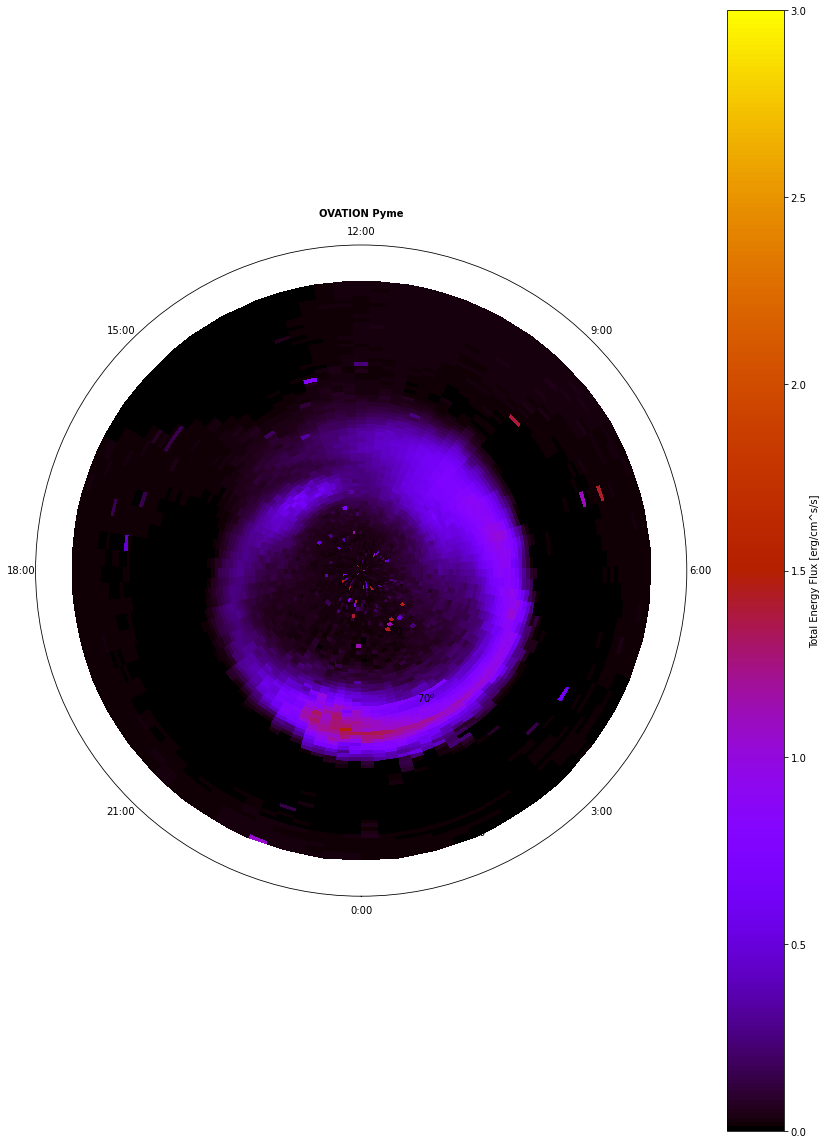

In [24]:
from ovationpyme.ovation_prime import FluxEstimator,AverageEnergyEstimator,BinCorrector
from ovationpyme.ovation_utilities import calc_avg_solarwind
from ovationpyme.ovation_plotting import latlt2polar,polar2dial,pcolor_flux

subplotlist=[]
fig= plt.figure(figsize=(12,16))
subplotlist = plt.subplot(polar=True)

# pcolor_kwargs = {'cmap':'gnuplot','vmin': 10**7.5*1.60218e-12,'vmax': 10**12.5*1.60218e-12}
pcolor_kwargs = {'cmap':'gnuplot','vmin': 0,'vmax': 3}
mappableN = pcolor_flux( subplotlist,mlat_grid_ovation,mlt_grid_ovation,eFlux_ovation_full,'N',**pcolor_kwargs)

subplotlist.set_title('OVATION Pyme',pad =10,fontweight="bold", fontsize='medium')


subplotlist.set_theta_zero_location('S')
theta_label_values = np.array([0.,3.,6.,9.,12.,15.,18.,21.])*180./12
theta_labels = ['%d:00' % (int(th/180.*12)) for th in theta_label_values.flatten().tolist()]
subplotlist.set_thetagrids(theta_label_values,labels=theta_labels,fontsize='medium', )

r_label_values = 90.-np.array([80.,70.,60.,50.])
r_labels = [r'$%d^{o}$' % (int(90.-rv)) for rv in r_label_values.flatten().tolist()]
subplotlist.set_rgrids(r_label_values,labels=r_labels)
subplotlist.set_rlim([0.,45.])

#         subplotlist.scatter(np.ones((20))*23/24*2*3.14159 ,                   np.linspace(0,40,20)      )     

plt.colorbar(mappableN,label='Total Energy Flux [erg/cm^s/s]')        

fig.tight_layout() 
#         fig.set_title('Log10 Predicted Electron Precipitation Energy Flux')
plt.show()

In [27]:
# Save the output so these data can be used

da = xarray.DataArray(

        data=eFlux_ovation_full,

        dims=["x", "y"],

        coords=dict(

            mlt=(["x", "y"], mlt_grid_ovation),

            lat=(["x", "y"], mlat_grid_ovation),

            time=datetime_input,


        ),

        attrs=dict(

            description="Auroral Energy Flux.",

            units="erg/cm^s/s",

        ),

)

da.to_netcdf(data_folder / 'halloween_storm_aurora.nc')